Posterior x: mean=0.544, q05=0.312, q95=0.777
ESS mean over restricted grid: 0.316
ESS support min/max: 0.298 / 0.332


/tmp/ipykernel_1355745/481577817.py:30: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-a * (P - P50)))
/tmp/ipykernel_1355745/481577817.py:223: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(s_grid, ess_pmf / np.trapz(ess_pmf, s_grid), linewidth=2, label="ESS (community, restricted grid)")


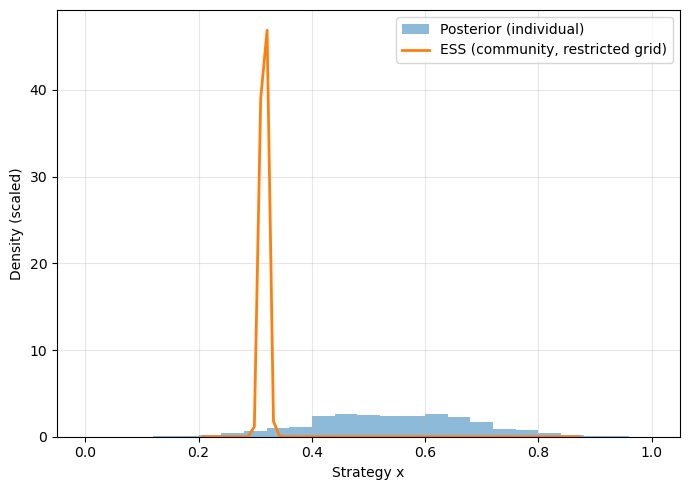

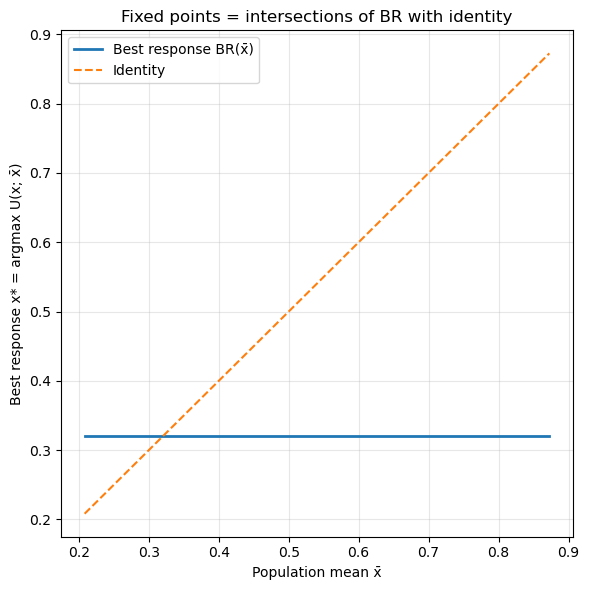

In [1]:
"""
OWUS posterior -> ESS pipeline (fake data)

1) Create a fake OWUS posterior over shape/trait-like params (fww, s_star, s_w, P50, K_max, a, Vcmax, Jmax, Rd, etc.).
2) Map the posterior to:
   a) an "individual optimality" proxy strategy distribution (x_post in [0,1]),
   b) "community_params" (aggregate parameters) for your WaterUseGame.
3) Run replicator dynamics to get an ESS distribution of strategies given the competition factor.
4) Compare posterior strategy distribution vs ESS distribution and print interpretable summaries.
"""

# Takes a posterior-derived “individual optimality” strategy distribution (x_post)
# and a replicator-dynamics ESS strategy distribution that emerges from competition (strategy_fraction on a discrete grid).
# Uses diagnostics comparing ESS mean vs posterior mean to infer whether community interactions push the system toward more conservative 
# or more aggressive water use — i.e., a direct lens on the spatial scale of optimality.

# if the ESS sits inside the posterior’s credible range but toward the low end, 
# it means that—given shared soil water and competition—plants that are more conservative with water (lower x) 
# tend to do better against the population than the individually “best” (posterior-mean) strategy. 
# So the community pushes behavior toward lower conductance / transpiration than what you’d infer from single-plant optimality.

import numpy as np
import matplotlib.pyplot as plt

# ---------- helpers ----------
D = 1.6
Gamma = 40.0

def vulnerability_curve(P, P50, a):
    return 1.0 / (1.0 + np.exp(-a * (P - P50)))

def hydraulic_conductance(P, P50, a, K_max):
    return K_max * vulnerability_curve(P, P50, a, K_max)

def hydraulic_conductance(P, P50, a, K_max):
    return K_max * vulnerability_curve(P, P50, a)

def find_critical_P(P_soil, P50, a, K_max, P_crit_threshold=0.30):
    # NOTE: stricter threshold (30% of Kmax), earlier failure ⇒ smaller Ecrit
    Ps = np.linspace(P_soil, -10.0, 2000)
    K_vals = hydraulic_conductance(Ps, P50, a, K_max)
    idx = np.where(K_vals <= P_crit_threshold * K_max)[0]
    return Ps[idx[0]] if idx.size > 0 else Ps[-1]

def E_to_P(E, P_soil, P50, a, K_max):
    if E <= 0:
        return P_soil
    P = P_soil - E / max(K_max, 1e-8)
    tol = 1e-6
    for _ in range(150):
        K = hydraulic_conductance(P, P50, a, K_max)
        f = K * (P_soil - P) - E
        if abs(f) < tol:
            return P
        exp_term = np.exp(a * (P - P50))
        dKdP = K_max * (-a * exp_term) / ((1 + exp_term) ** 2)
        dfdP = dKdP * (P_soil - P) - K
        if abs(dfdP) < 1e-10:
            break
        P -= f / dfdP
    return P

def E_crit(P_soil, P50, a, K_max, P_crit_threshold=0.30):
    Pcrit = find_critical_P(P_soil, P50, a, K_max, P_crit_threshold)
    return max(0.0, K_max * (P_soil - Pcrit))

def farquhar_photosynthesis(Ci, Vcmax, Jmax, Rd):
    Wc = Vcmax * (Ci - Gamma) / (Ci + 245.0)
    Wj = Jmax * (Ci - Gamma) / (4.0 * Ci + 8.0 * Gamma)
    return max(0.0, min(Wc, Wj) - Rd)

def E_to_Ci_phys(E, Ca, E_half):
    """
    Physiologically sensible: as E (and thus g_s) increases, Ci rises
    from Γ toward Ca, saturating with scale E_half.
    """
    frac = E / (E + max(E_half, 1e-8))
    Ci = Gamma + (Ca - Gamma) * frac
    return float(np.clip(Ci, Gamma + 1.0, Ca - 1.0))


# ---------- game with bounded physiology and custom strategy grid ----------
class WaterUseGame:
    def __init__(self, community_params, strategies):
        self.community_params = community_params
        self.strategies = strategies  # pass a restricted grid

    def calculate_payoff(self, strategy, community_strategy):
        cp = self.community_params
        E = strategy * cp['E_crit_max']

        # bounded Ci; choose E_half as a moderate fraction of feasible E
        Ci = E_to_Ci_phys(E, cp['Ca'], E_half=0.3 * cp['E_crit_max'])

        A = farquhar_photosynthesis(Ci, cp['Vcmax'], cp['Jmax'], cp['Rd'])
        water_penalty = np.exp(-cp['competition_factor'] * community_strategy)

        P_leaf = E_to_P(E, cp['P_soil'], cp['P50'], cp['a'], cp['K_max'])
        K_leaf = hydraulic_conductance(P_leaf, cp['P50'], cp['a'], cp['K_max'])
        hydraulic_risk = 1.0 - K_leaf / max(cp['K_max'], 1e-12)

        payoff = A * water_penalty * (1.0 - hydraulic_risk)
        # keep payoffs nonnegative for numeric stability
        return max(0.0, payoff)

def replicator_ESS(game, max_gens=3000, tol=1e-7):
    s = game.strategies
    n = len(s)
    pay = np.zeros((n, n))
    for i, xi in enumerate(s):
        for j, xbar in enumerate(s):
            pay[i, j] = game.calculate_payoff(xi, xbar)

    # avoid zero columns (pathological cases)
    col_min = np.minimum(0.0, np.min(pay, axis=0))
    pay = pay - col_min  # shift each column to be ≥ 0

    p = np.ones(n) / n
    for _ in range(max_gens):
        avg_payoff = pay @ p
        total = float(p @ avg_payoff) + 1e-12
        p_new = p * (avg_payoff / total)
        p_new = p_new / max(np.sum(p_new), 1e-12)
        if np.max(np.abs(p_new - p)) < tol:
            p = p_new
            break
        p = p_new

    support = p > (1.0 / n) * 0.05
    return s[support], p, pay

# ---------- posterior plumbing (same idea, minor tweaks) ----------
def fake_owus_posterior(M=1000, seed=7): # ESS < posterior
    rng = np.random.default_rng(seed)
    fww    = 0.4 + 0.4 * rng.beta(4, 3, size=M)
    s_star = np.clip(rng.normal(0.40, 0.07, size=M), 0.25, 0.55)
    s_w    = np.clip(rng.normal(0.12, 0.03, size=M), 0.05, 0.20)
    s_w    = np.minimum(s_w, s_star - 0.02)

    P50    = rng.normal(-2.5, 0.5, size=M)
    a_vuln = np.clip(rng.normal(2.0, 0.5, size=M), 0.5, 4.0)
    K_max  = np.clip(rng.normal(0.03, 0.01, size=M), 0.005, 0.08)

    Vcmax  = np.clip(rng.normal(85.0, 25.0, size=M), 20.0, 160.0)
    Jmax   = np.clip(rng.normal(170.0, 40.0, size=M), 60.0, 300.0)
    Rd     = np.clip(rng.normal(2.0, 0.7, size=M), 0.5, 4.0)

    Ca     = rng.normal(415.0, 5.0, size=M)
    VPD    = np.clip(rng.normal(1.6, 0.5, size=M), 0.3, 4.0)
    P_soil = rng.normal(-0.6, 0.2, size=M)
    comp   = np.clip(rng.normal(2.0, 0.6, size=M), 0.2, 4.5)

    return {
        "fww": fww, "s_star": s_star, "s_w": s_w,
        "P50": P50, "a": a_vuln, "K_max": K_max,
        "Vcmax": Vcmax, "Jmax": Jmax, "Rd": Rd,
        "Ca": Ca, "VPD": VPD, "P_soil": P_soil,
        "competition_factor": comp
    }

def owus_to_strategy(fww, s_star, s_w, w_fww=0.6, w_thresh=0.4):
    f_norm = (fww - 0.4) / (0.8 - 0.4)
    t_norm = (0.55 - s_star) / (0.55 - 0.25)
    x = w_fww * f_norm + w_thresh * t_norm
    return np.clip(x, 0.0, 1.0)

def community_params_from_posterior(post):
    P50  = float(np.mean(post["P50"]))
    a    = float(np.mean(post["a"]))
    Kmax = float(np.mean(post["K_max"]))
    Psm  = float(np.mean(post["P_soil"]))
    Ca   = float(np.mean(post["Ca"]))
    VPD  = float(np.mean(post["VPD"]))
    Vc   = float(np.mean(post["Vcmax"]))
    Jm   = float(np.mean(post["Jmax"]))
    Rd   = float(np.mean(post["Rd"]))
    comp = float(np.mean(post["competition_factor"]))
    Ecrit = E_crit(Psm, P50, a, Kmax, P_crit_threshold=0.30)
    if not np.isfinite(Ecrit) or Ecrit <= 0:
        Ecrit = max(1e-3, 0.02 * Kmax)
    return {"E_crit_max": Ecrit, "P50": P50, "K_max": Kmax, "a": a, "P_soil": Psm,
            "competition_factor": comp, "Ca": Ca, "VPD": VPD, "Vcmax": Vc, "Jmax": Jm, "Rd": Rd}

# ---------- NEW: restrict strategy grid to posterior support ----------
def strategy_grid_from_posterior(x_post, pad=0.05, n=60):
    lo = float(np.quantile(x_post, 0.02))
    hi = float(np.quantile(x_post, 0.98))
    lo = max(0.0, lo - pad)
    hi = min(1.0, hi + pad)
    if hi <= lo + 1e-6:
        lo, hi = 0.05, 0.95
    return np.linspace(lo, hi, n)

# ---------- Diagnostics: best response curve ----------
def best_response_curve(game):
    s = game.strategies
    br = np.zeros_like(s)
    for j, xbar in enumerate(s):
        pay = np.array([game.calculate_payoff(xi, xbar) for xi in s])
        br[j] = s[np.argmax(pay)]
    return br

# ---------- Run ----------
if __name__ == "__main__":
    post = fake_owus_posterior(M=1000, seed=7)
    x_post = owus_to_strategy(post["fww"], post["s_star"], post["s_w"])
    comm = community_params_from_posterior(post)
    s_grid = strategy_grid_from_posterior(x_post, pad=0.05, n=60)

    game = WaterUseGame(comm, strategies=s_grid)
    ess_strats, ess_pmf, payoff_matrix = replicator_ESS(game)

    # summaries
    print(f"Posterior x: mean={np.mean(x_post):.3f}, q05={np.quantile(x_post,0.05):.3f}, q95={np.quantile(x_post,0.95):.3f}")
    ess_mean = float(np.sum(s_grid * ess_pmf))
    print(f"ESS mean over restricted grid: {ess_mean:.3f}")
    print(f"ESS support min/max: {s_grid[ess_pmf>0.001].min():.3f} / {s_grid[ess_pmf>0.001].max():.3f}")

    # plots
    bins = np.linspace(0, 1, 26)
    plt.figure(figsize=(7,5))
    plt.hist(x_post, bins=bins, density=True, alpha=0.5, label="Posterior (individual)")
    plt.plot(s_grid, ess_pmf / np.trapz(ess_pmf, s_grid), linewidth=2, label="ESS (community, restricted grid)")
    plt.xlabel("Strategy x")
    plt.ylabel("Density (scaled)")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
    #plt.savefig("posterior_vs_ess_restricted.png", dpi=220)
    plt.show()

    # best-response curve
    br = best_response_curve(game)
    plt.figure(figsize=(6,6))
    plt.plot(s_grid, br, linewidth=2, label="Best response BR(x̄)")
    plt.plot(s_grid, s_grid, linestyle="--", linewidth=1.5, label="Identity")
    plt.xlabel("Population mean x̄"); plt.ylabel("Best response x* = argmax U(x; x̄)")
    plt.title("Fixed points = intersections of BR with identity")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
    #plt.savefig("best_response_curve.png", dpi=220)
    plt.show()
